In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

2024-09-23 15:49:44.553113: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 15:49:44.738413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 15:49:44.809322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 15:49:44.830370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 15:49:44.968370: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df =  pd.read_csv("all_tnx.csv")

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[df.drop(columns=["address", "timeWindow", "is_reputable"]).columns] = scaler.fit_transform(df[df.drop(columns=["address", "timeWindow", "is_reputable"]).columns])

sequence_lengths = df.groupby('address').size()
max_timesteps = int(np.percentile(sequence_lengths, 75))

In [3]:
max_timesteps

1875

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, ZeroPadding1D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt

# Define basic mean squared error loss
def mse(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
# Define the CAE model with extended hyperparameters
class CAEHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        input_seq = Input(shape=self.input_shape)

        # Encoder
        x = Conv1D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16), 
                   kernel_size=hp.Choice('kernel_size_1', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_1', min_value=0, max_value=0.1, step=0.01)))(input_seq)
        x = MaxPooling1D(pool_size=hp.Choice('pool_size_1', values=[2, 4]), padding='same')(x)
        x = Dropout(hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1))(x)
        x = Conv1D(filters=hp.Int('filters_2', min_value=8, max_value=32, step=8), 
                   kernel_size=hp.Choice('kernel_size_2', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_2', min_value=0, max_value=0.1, step=0.01)))(x)
        encoded = MaxPooling1D(pool_size=hp.Choice('pool_size_2', values=[2, 4]), padding='same')(x)

        # Decoder
        x = Conv1D(filters=hp.Int('filters_2', min_value=8, max_value=32, step=8), 
                   kernel_size=hp.Choice('kernel_size_2', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same')(encoded)
        x = UpSampling1D(size=hp.Choice('up_sampling_size_1', values=[2, 4]))(x)
        x = Dropout(hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1))(x)
        x = Conv1D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16), 
                   kernel_size=hp.Choice('kernel_size_1', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same')(x)
        x = UpSampling1D(size=hp.Choice('up_sampling_size_2', values=[2, 4]))(x)
        
        # Adjust the final output to match the original input sequence length
        x = x[:, :max_timesteps, :]
        decoded = Conv1D(self.input_shape[1], kernel_size=3, activation='sigmoid', padding='same')(x)

        # decoded = decoded[:, :self.input_shape[0], :]  # Ensure the output has the same length as the input
        model = Model(input_seq, decoded)
        model.compile(optimizer=tf.keras.optimizers.Adam(
                          hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='mse')
        return model

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))  # Ensure the output is a float

lr_scheduler = LearningRateScheduler(scheduler)

# Data preparation
def prepare_data(df, max_timesteps):
    # Prepare data for reputable contracts
    reputable_df = df[df['is_reputable'] == 1]
    sequences = [group[df.drop(columns=["address", "timeWindow", "is_reputable"]).columns].values
                 for _, group in reputable_df.groupby('address')]
    X = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', truncating='post')
    return X

In [7]:
X = prepare_data(df, max_timesteps)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import keras_tuner as kt
import numpy as np
# Function to perform K-Fold Cross-Validation and Batch size tuning
from sklearn.model_selection import TimeSeriesSplit

def train_and_evaluate(df, max_timesteps, batch_sizes=[16, 32, 64], time_based=False):
  

    histories = {}
    tuning_results = []  # Store tuning results

    for batch_size in batch_sizes:
        fold_no = 1
        
        # Reinitialize the split generator for each batch size
        tscv = TimeSeriesSplit(n_splits=5)
        split_generator = tscv.split(X)
        
        for train_index, val_index in split_generator:
            X_train, X_val = X[train_index], X[val_index]
            
            # Define the model
            hypermodel = CAEHyperModel(input_shape=(max_timesteps, X.shape[2]))
            tuner = kt.RandomSearch(
                hypermodel,
                objective='val_loss',
                max_trials=5,
                executions_per_trial=1,
                directory='tuner_dir',
                project_name=f'cae_tuning_tnx_{batch_size}'
            )

            # Perform hyperparameter search WITHOUT the LearningRateScheduler
            tuner.search(X_train, X_train, epochs=30, batch_size=batch_size, validation_data=(X_val, X_val))

            # Get the best hyperparameters and store them
            best_hp = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
            # tuning_results.append({
            #     'batch_size': batch_size,
            #     'fold': fold_no,
            #     'best_filters_1': best_hp['filters_1'],
            #     'best_filters_2': best_hp['filters_2'],
            #     'learning_rate': best_hp['learning_rate'],
            #     'val_loss': tuner.oracle.get_best_trials(1)[0].get_best_value('val_loss') 
            # })

            best_trial = tuner.oracle.get_best_trials(1)[0]
            val_loss_history = best_trial.metrics.get_history('val_loss')
            best_val_loss = val_loss_history[-1]  # Get the last validation loss value (best)

            # Append the results including best validation loss
            tuning_results.append({
                'batch_size': batch_size,
                'fold': fold_no,
                'best_filters_1': best_hp['filters_1'],
                'best_filters_2': best_hp['filters_2'],
                'learning_rate': best_hp['learning_rate'],
                'activation': best_hp['activation'], 
                'kernel_size_1': best_hp['kernel_size_1'],
                'kernel_size_2': best_hp['kernel_size_2'],
                'l2_reg_1': best_hp['l2_reg_1'],
                'l2_reg_2': best_hp['l2_reg_2'],
                'pool_size_1': best_hp['pool_size_1'],
                'pool_size_1': best_hp['pool_size_2'],
                'dropout_1': best_hp['dropout_1'],
                'dropout_2': best_hp['dropout_2'],
                'up_sampling_size_1': best_hp['up_sampling_size_1'],
                'up_sampling_size_2': best_hp['up_sampling_size_2'],
                'val_loss': best_val_loss
            })

            # Get the best model
            best_model = tuner.get_best_models(num_models=1)[0]
            best_model.save(f"cae_tnx_{batch_size}.keras")

            # Now fit the best model with the LearningRateScheduler
            history = best_model.fit(
                X_train, X_train,
                epochs=30,
                batch_size=batch_size,
                validation_data=(X_val, X_val),
                callbacks=[lr_scheduler]  # Add the scheduler after finding the best model
            )

            # Initialize histories for the current batch size if not done already
            if batch_size not in histories:
                histories[batch_size] = {'train_loss': [], 'val_loss': []}
                
            # Collect the loss histories for the current fold
            histories[batch_size]['train_loss'].append(history.history['loss'])
            histories[batch_size]['val_loss'].append(history.history['val_loss'])
            
            fold_no += 1
    
    # Plot training and validation loss for different batch sizes
    plt.figure(figsize=(12, 6))
    for batch_size in batch_sizes:
        # Safeguard against missing data
        if batch_size in histories:
            train_loss_avg = np.mean(histories[batch_size]['train_loss'], axis=0)
            val_loss_avg = np.mean(histories[batch_size]['val_loss'], axis=0)
            
            # Create a new figure for each batch size
            plt.figure(figsize=(8, 5))
            plt.plot(train_loss_avg, label=f'Training Loss (batch={batch_size})')
            plt.plot(val_loss_avg, '--', label=f'Validation Loss (batch={batch_size})')
            
            # Set plot title and labels
            plt.title(f'Training and Validation Loss for Batch Size {batch_size}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Show the plot
            plt.show()
    
    # Hyperparameter tuning results as a DataFrame
    tuning_df = pd.DataFrame(tuning_results)
    
    # Print the hyperparameter tuning results
    print("\nHyperparameter Tuning Results:")
    print(tuning_df)

    # Save the tuning results to a CSV for later analysis
    tuning_df.to_csv('hyperparameter_tuning_results_tnx.csv', index=False)

    return best_model, tuning_df

Trial 5 Complete [00h 00m 01s]

Best val_loss So Far: 0.02644342929124832
Total elapsed time: 00h 00m 22s
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 825ms/step - loss: 0.0248 - val_loss: 0.0180 - learning_rate: 0.0026
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0169 - val_loss: 0.0127 - learning_rate: 0.0026
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0120 - val_loss: 0.0094 - learning_rate: 0.0026
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0089 - val_loss: 0.0070 - learning_rate: 0.0026
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0067 - val_loss: 0.0052 - learning_rate: 0.0026
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0049 - val_loss: 0.0036 - learning_rate: 0.0026
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0034 - val_loss: 0.0024 - learning_rate: 0.0026
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 0.0026
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

<Figure size 1200x600 with 0 Axes>

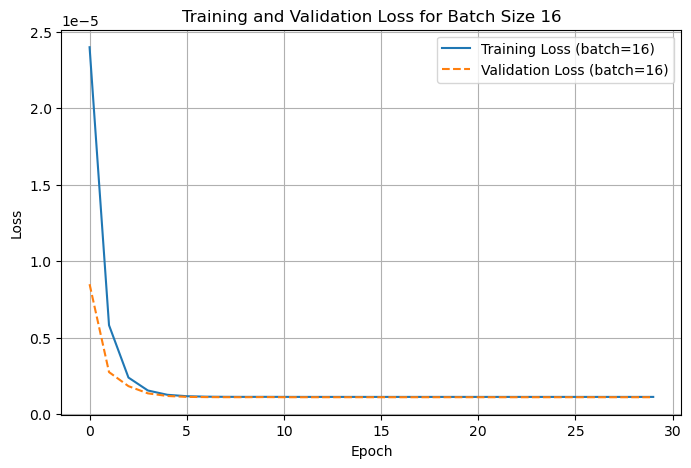

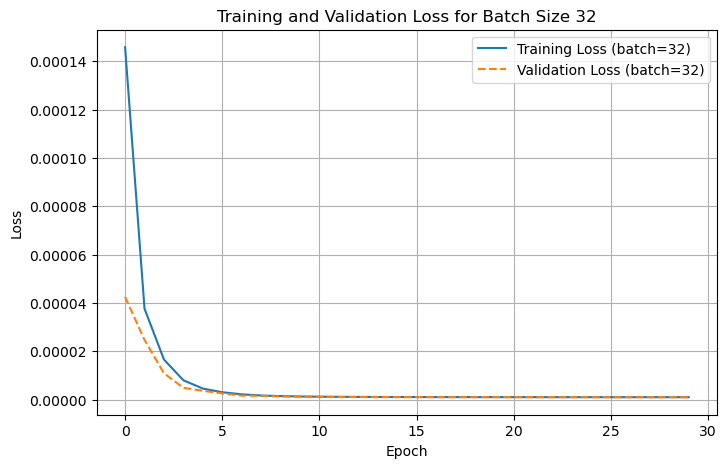

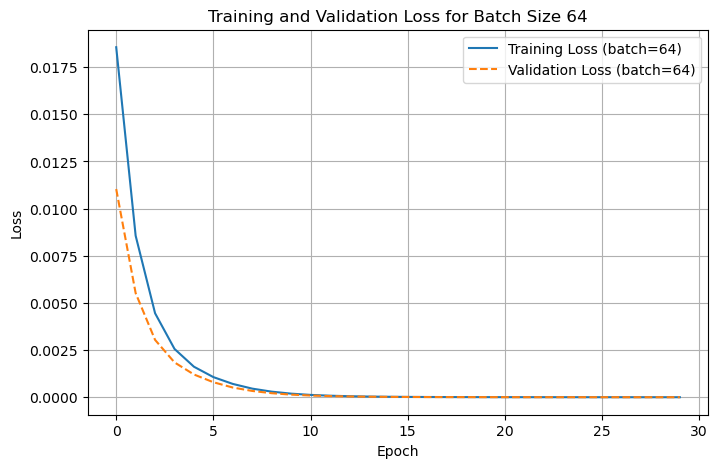


Hyperparameter Tuning Results:
    batch_size  fold  best_filters_1  best_filters_2  learning_rate  \
0           16     1              16              16       0.008358   
1           16     2              16              16       0.008358   
2           16     3              16              16       0.008358   
3           16     4              16              16       0.008358   
4           16     5              16              16       0.008358   
5           32     1              16              24       0.002789   
6           32     2              16              24       0.002789   
7           32     3              16              24       0.002789   
8           32     4              16              24       0.002789   
9           32     5              16              24       0.002789   
10          64     1              16              16       0.002584   
11          64     2              16              16       0.002584   
12          64     3              16         

In [9]:
model, tuning_df = train_and_evaluate(df, max_timesteps)

In [10]:
df.columns

Index(['timeWindow', 'address', 'value_sum', 'value_mean', 'gas_sum',
       'gas_mean', 'gasPrice_sum', 'gasPrice_mean', 'isError_sum',
       'unique_received_from', 'is_reputable'],
      dtype='object')

In [4]:
import cupy as cp
# all_sequences = []
# all_addresses = []

# for address in df['address'].unique():
#     group = df[df['address'] == address].sort_values(by='timeWindow')
#     sequence = group[df.drop(columns=["address", "timeWindow", "is_reputable"]).columns].values
#     sequence = pad_sequences([sequence], maxlen=max_timesteps, dtype='float32', padding='post', truncating='post')
#     all_sequences.append(sequence[0])
#     all_addresses.append(address)

# X_all = np.array(all_sequences)
# cp.save("X_all_tnx_sequence.npy", X_all)
X_all = cp.load("X_all_tnx_sequence.npy").get()
all_addresses = list(df['address'].unique())
model = tf.keras.models.load_model("cae_tnx_16.keras")

I0000 00:00:1727099437.739494  274549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727099437.870221  274549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727099437.870352  274549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727099437.873388  274549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727099437.873466  274549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [34]:
X_all_no_label = X_all[:, :, :]
reconstructions = model.predict(X_all)
reconstructions_no_label = reconstructions[:, :, :]

# Calculate reconstruction error per transaction (average over feature dimension)
reconstruction_error_per_transaction = np.mean(np.abs(reconstructions_no_label - X_all_no_label), axis=2)
# reconstruction_error_per_transaction = np.abs(reconstructions_no_label - X_all_no_label), axis=

# Create a DataFrame with the transaction-level reconstruction errors
# Flatten the array to have one row per transaction, with the corresponding address repeated
reconstruction_error_df = pd.DataFrame({
    'address': np.repeat(all_addresses, X_all_no_label.shape[1]),
    'reconstruction_error': reconstruction_error_per_transaction.flatten()
})

# Optional: Add timestep index to track the position of each transaction within the sequence
reconstruction_error_df['timestep'] = np.tile(np.arange(X_all_no_label.shape[1]), len(all_addresses))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [32]:
df.columns

Index(['timeWindow', 'address', 'value_sum', 'value_mean', 'gas_sum',
       'gas_mean', 'gasPrice_sum', 'gasPrice_mean', 'isError_sum',
       'unique_received_from', 'is_reputable'],
      dtype='object')

In [35]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale reconstruction error and apply sigmoid
reconstruction_error_df['scaled_rec_error'] = MinMaxScaler((0, 10)).fit_transform(reconstruction_error_df[['reconstruction_error']])
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

reconstruction_error_df['tnx_rep_score'] = 1 - sigmoid(reconstruction_error_df['scaled_rec_error'])

# Rescale tnx_rep_score to 0-1 range
reconstruction_error_df['rep_score'] = MinMaxScaler().fit_transform(reconstruction_error_df[['tnx_rep_score']])


In [104]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# Define the search space for thresholds
thresholds = np.arange(50, 90, 5)  # Percentiles for reconstruction error threshold
contract_thresholds = np.arange(0.1, 1.0, 0.1)  # Contract-level anomaly thresholds
k = np.arange(1.5, 3, 0.1)
# Variables to store the best metrics
best_f1 = 0
best_params = {}

# Iterate over each combination of thresholds
for thresh in thresholds:
    for k_val in k:
        for contract_thresh in contract_thresholds:
            # Calculate transaction-level anomaly threshold using IQR approach
            q1 = np.percentile(reconstruction_error_df['reconstruction_error'], 25)
            q3 = np.percentile(reconstruction_error_df['reconstruction_error'], 75)
            iqr = q3 - q1
            transaction_threshold = q3 + k_val * iqr
            
            # Mark transactions as anomalous
            reconstruction_error_df['is_anomalous'] = reconstruction_error_df['reconstruction_error'] > transaction_threshold

            # Calculate contract-level anomaly scores
            contract_anomaly_scores = reconstruction_error_df.groupby('address')['is_anomalous'].mean()
            predicted_illicit = contract_anomaly_scores > contract_thresh

            # Merge with the actual labels for evaluation
            results_df = pd.DataFrame({
                'address': contract_anomaly_scores.index,
                'anomaly_score': contract_anomaly_scores.values,
                'predicted_illicit': predicted_illicit,
                'actual_illicit': df.groupby('address')['is_reputable'].first().apply(lambda x: 1 - x)
            })

            # Calculate evaluation metrics
            f1 = f1_score(results_df['actual_illicit'], results_df['predicted_illicit'])
            
            # Check if this combination is better
            if f1 > best_f1:
                best_f1 = f1
                best_params = {'threshold': transaction_threshold, 'k':k_val, 'contract_threshold': contract_thresh}

# Output the best parameters and F1-score
print(f"Best F1-score: {best_f1}")
print(f"Best parameters: {best_params}")


Best F1-score: 0.5
Best parameters: {'threshold': 0.0014813155623483176, 'k': 1.5, 'contract_threshold': 0.30000000000000004}


In [43]:
reconstruction_error_df['scaled_rec_error'] = MinMaxScaler((0, 10)).fit_transform(reconstruction_error_df[['reconstruction_error']])

In [55]:
df.groupby('address')['is_reputable'].first()

address
0x0000000000095413afc295d19edeb1ad7b71c952    1
0x0001a500a6b18995b03f44bb040a5ffc28e45cb0    1
0x0018d5e01e53878f90feab02f1b2019a21adf8b1    1
0x0058c8581b9fed6864faa654505bc89890cdb2dd    1
0x0080428794a79a40ae03cf6e6c1d56bd5467a4a2    1
                                             ..
0xff20817765cb7f73d4bde2e66e067e58d11095c2    1
0xff75ced57419bcaebe5f05254983b013b0646ef5    1
0xff836a5821e69066c87e268bc51b849fab94240c    1
0xff9c1f21c621696c4f91cf781ec31bd913ee2c26    1
0xffe203b59393593965842439ce1e7d7c78109b46    1
Name: is_reputable, Length: 1071, dtype: int64

In [53]:
reconstruction_error_df['is_reputable'] = df.groupby('address')['is_reputable'].first()

In [65]:
df_first_entry = df.groupby('address').first().reset_index()

# Step 2: Merge the first entry of df with reconstruction_error_df based on 'address'
reconstruction_error_df = reconstruction_error_df.merge(df_first_entry[['address', 'is_reputable']], on='address', how='left')


In [68]:
from scipy.stats import mannwhitneyu

# Split reconstruction_error based on is_reputable
reputable_errors = reconstruction_error_df[reconstruction_error_df['is_reputable'] == 1]['reconstruction_error']
illicit_errors = reconstruction_error_df[reconstruction_error_df['is_reputable'] == 0]['reconstruction_error']

# Conduct Mann-Whitney U test
stat, p_value = mannwhitneyu(reputable_errors, illicit_errors, alternative='two-sided')

# Print the result
print(f"Statistic: {stat}, p-value: {p_value}")


Statistic: 68465207923.0, p-value: 0.0


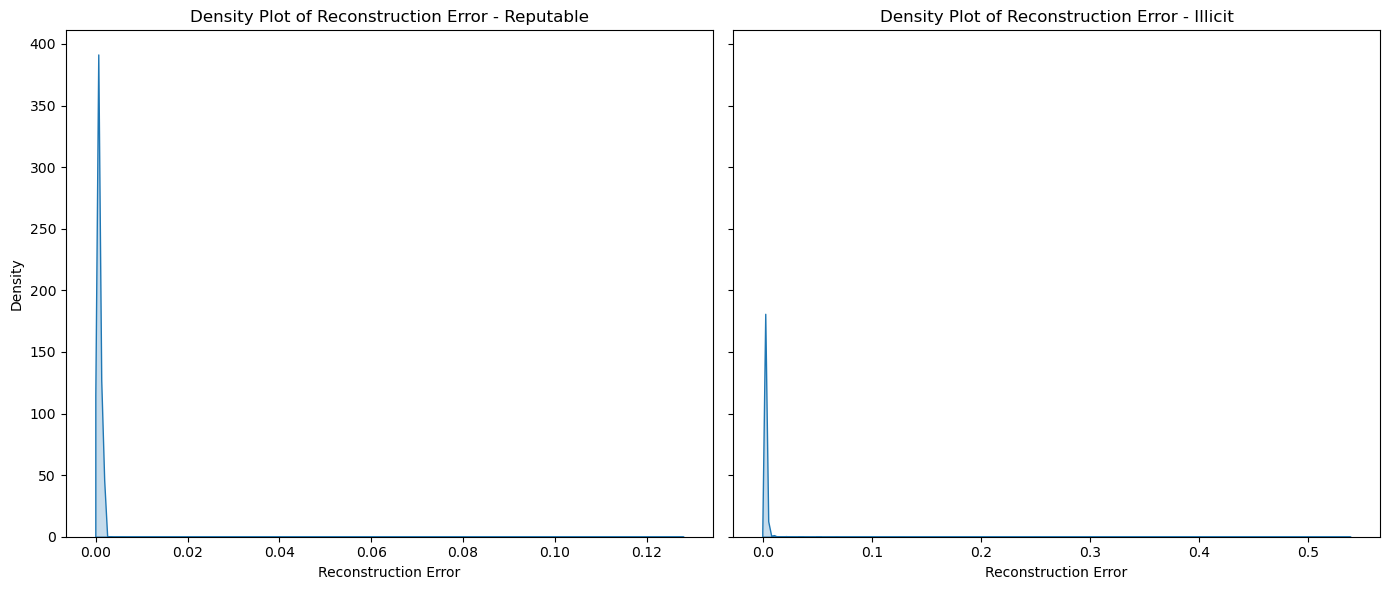

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Density plot for reputable transactions
sns.kdeplot(data=reconstruction_error_df[reconstruction_error_df['is_reputable'] == 1], x='reconstruction_error', fill=True, ax=axes[0])
axes[0].set_title('Density Plot of Reconstruction Error - Reputable')
axes[0].set_xlabel('Reconstruction Error')
axes[0].set_ylabel('Density')

# Density plot for illicit transactions
sns.kdeplot(data=reconstruction_error_df[reconstruction_error_df['is_reputable'] == 0], x='reconstruction_error', fill=True, ax=axes[1])
axes[1].set_title('Density Plot of Reconstruction Error - Illicit')
axes[1].set_xlabel('Reconstruction Error')

# Show the plots
plt.tight_layout()
plt.show()


In [89]:
test_df = reconstruction_error_df.groupby('address').first().reset_index()
test_df['is_reputable']

0       1
1       1
2       1
3       1
4       1
       ..
1066    1
1067    1
1068    1
1069    1
1070    1
Name: is_reputable, Length: 1071, dtype: int64

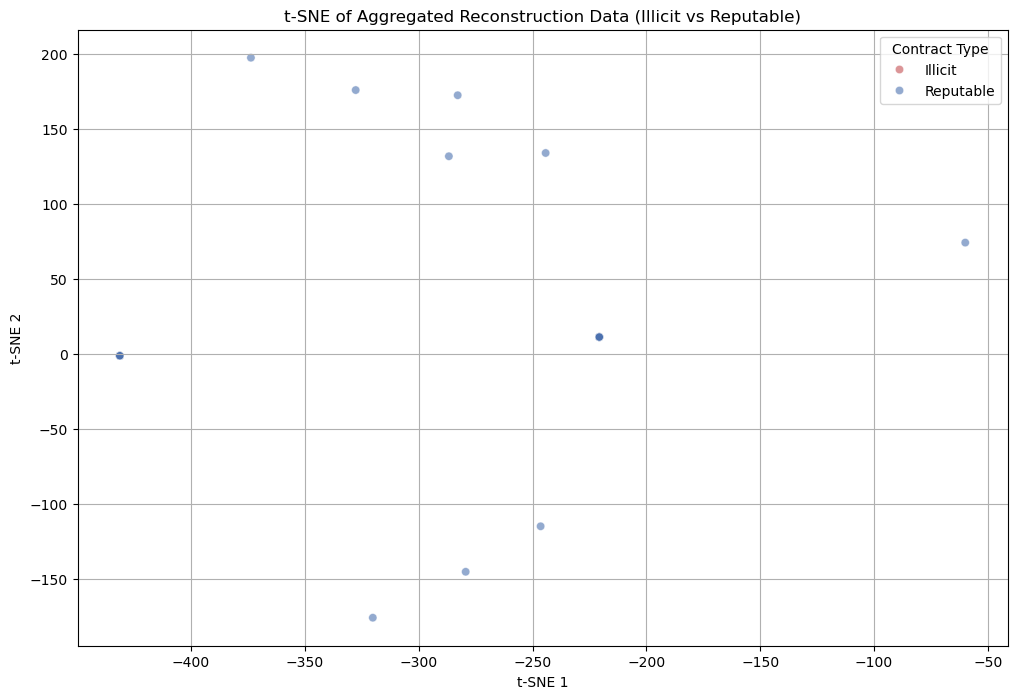

In [90]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Aggregate by averaging across timesteps
X_aggregated = np.mean(reconstructions_no_label, axis=1)  # Shape will become (864, 58)

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_aggregated)

# Step 3: Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame({
    't-SNE 1': tsne_results[:, 0],
    't-SNE 2': tsne_results[:, 1],
    'is_reputable': test_df['is_reputable']
})
# colors = ['#4C72B0','#C44E52']
# Step 4: Plot the t-SNE results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2',
    hue='is_reputable',
    palette={0:'#C44E52', 1:'#4C72B0'},
    data=tsne_df,
    legend="full",
    alpha=0.6
)

# Use the correct hue_order and automatically generate the legend labels
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles=handles, labels=['Illicit', 'Reputable'], title='Contract Type')

plt.title('t-SNE of Aggregated Reconstruction Data (Illicit vs Reputable)')
plt.grid(True)
plt.show()


In [91]:
reconstruction_error_df

,address,reconstruction_error,timestep,scaled_rec_error,tnx_rep_score,rep_score,is_anomalous,is_reputable
0,0x4da9b813057d04baef4e5800e36083717b4a0341,1.410551e-03,0,0.026224,0.493444,0.986887,True,1
1,0x4da9b813057d04baef4e5800e36083717b4a0341,1.326405e-05,1,0.000246,0.499938,0.999877,False,1
2,0x4da9b813057d04baef4e5800e36083717b4a0341,3.406882e-06,2,0.000063,0.499984,0.999968,False,1
3,0x4da9b813057d04baef4e5800e36083717b4a0341,9.647356e-07,3,0.000018,0.499996,0.999991,False,1
4,0x4da9b813057d04baef4e5800e36083717b4a0341,9.647356e-07,4,0.000018,0.499996,0.999991,False,1
...,...,...,...,...,...,...,...,...
2008120,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,1.338460e-08,1870,0.000000,0.500000,1.000000,False,0
2008121,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,1.338460e-08,1871,0.000000,0.500000,1.000000,False,0
2008122,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,1.338460e-08,1872,0.000000,0.500000,1.000000,False,0
2008123,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,1.338460e-08,1873,0.000000,0.500000,1.000000,False,0


In [105]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# reconstruction_error = np.mean(np.abs(reconstructions_no_label - X_all_no_label), axis=(1, 2))
# reconstruction_error_df = pd.DataFrame({
#     'address': all_addresses,
#     'reconstruction_error': reconstruction_error
# })
threshold = np.percentile(reconstruction_error_df['reconstruction_error'], 95)
# threshold = 0.0014813155623483176
reconstruction_error_df['is_anomalous'] = reconstruction_error_df['reconstruction_error'] > threshold

# Aggregate anomalies at the contract level
contract_anomaly_scores = reconstruction_error_df.groupby('address')['is_anomalous'].mean()
contract_threshold = 0.3
predicted_illicit = contract_anomaly_scores > contract_threshold

# Merge with the actual labels for evaluation
results_df = pd.DataFrame({
    'address': contract_anomaly_scores.index,
    'anomaly_score': contract_anomaly_scores.values,
    'predicted_illicit': predicted_illicit,
    'actual_illicit': df.groupby('address')['is_reputable'].first().apply(lambda x: 1 - x)  # 1 for illicit, 0 for reputable
})

# Evaluate the performance
print("Confusion Matrix:")
cm = confusion_matrix(results_df['actual_illicit'], results_df['predicted_illicit'])
print(cm)

print("\nClassification Report:")
print(classification_report(results_df['actual_illicit'], results_df['predicted_illicit'], digits=3))

print("\nAccuracy:")
print(accuracy_score(results_df['actual_illicit'], results_df['predicted_illicit']))


Confusion Matrix:
[[990   1]
 [ 53  27]]

Classification Report:
              precision    recall  f1-score   support

           0      0.949     0.999     0.973       991
           1      0.964     0.338     0.500        80

    accuracy                          0.950      1071
   macro avg      0.957     0.668     0.737      1071
weighted avg      0.950     0.950     0.938      1071


Accuracy:
0.9495798319327731


: 

In [95]:
np.percentile(reconstruction_error_df['rep_score'], 50)

1.0